In [1]:
%matplotlib widget
import torch
import os
import copy
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS, computeDT
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod

In [47]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
dtype = torch.float32

nx = 64
dim = 1
kernel = 'CubicSpline'
targetNeighbors = n_h_to_nH(8, dim)
CFL = 0.3
goalRadius = 0.8

nx = 256
rho0 = 1
E0 = 1
gamma = 1.4

scheme = 'CompSPH'
integrationScheme = 'RK2'
viscositySwitch = 'hopkins'
supportScheme = 'Owen'

domain = buildDomainDescription(l = 1, dim = dim, periodic = True, device = device, dtype = dtype)
domain.min = torch.tensor([0, 0], device = device, dtype = dtype)
domain.max = torch.tensor([1, 1], device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)

In [48]:
import numpy as np
# Function to sample particles such that their density equals a desired PDF
def samplePDF(pdf, n = 2048, numParticles = 256, plot = False, randomSampling = False):
    x = np.linspace(-1,1,n)
    if plot:
        fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

    n = 2048
    xs = np.linspace(-1,1,n)

    if plot:
        axis[0,0].plot(xs, pdf(xs))

    normalized_pdf = lambda x: pdf(x) / np.sum(pdf(np.linspace(-1,1,n)))
    if plot:
        axis[0,0].plot(xs, normalized_pdf(xs))
        axis[0,0].axhline(0,ls= '--', color = 'black')


    xs = np.linspace(-1,1,n)
    fxs = normalized_pdf(xs)
    sampled_cdf = np.cumsum(fxs) - fxs[0]
    sampled_cdf = sampled_cdf / sampled_cdf[-1] 
    inv_cdf = lambda x : np.interp(x, sampled_cdf, np.linspace(-1,1,n))

    samples = np.random.uniform(size = numParticles)
    if not randomSampling:
        samples = np.linspace(0,1,numParticles, endpoint=False)
    sampled = inv_cdf(samples)

    return sampled

In [49]:
from sphMath.util import volumeToSupport
from sphMath.sampling import ParticleSet
domain = buildDomainDescription(l = 2, dim = dim, periodic = True, device = device, dtype = dtype)
print(domain.min, domain.max)
pdf = lambda x: 0.1 * np.sin(4*x * np.pi) + 2

tensor([-1.]) tensor([1.])


In [50]:
positions = torch.tensor(samplePDF(pdf, n = 2048, numParticles = 1024, plot = False, randomSampling = False), device = device, dtype = dtype).view(-1,1)
masses = torch.ones_like(positions[:,0]) * (domain.max - domain.min)[0]/positions.shape[0] * 2
densities = torch.tensor(pdf(positions[:,0].cpu().numpy()), device = device, dtype = dtype)
supports = volumeToSupport(masses, targetNeighbors, 1)

particles_l = ParticleSet(positions, supports, masses, densities)


In [51]:

from sphMath.modules.compressible import CompressibleState
from sphMath.modules.density import computeDensity
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr

Pinitial = torch.zeros_like(particles_l.densities)
r = torch.linalg.norm(particles_l.positions, dim = -1)
rhoInitial = torch.ones_like(particles_l.densities)
v_initial = - torch.nn.functional.normalize(particles_l.positions, dim = -1)
# particles_l = particles_l._replace(masses = particles_l.masses * rhoInitial, densities = rhoInitial)

A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)

internalEnergy = u_ 
kineticEnergy = torch.linalg.norm(v_initial, dim = -1) **2/ 2
totalEnergy = (internalEnergy + kineticEnergy) * particles_l.masses

simulationState = CompressibleState(
    positions = particles_l.positions,
    supports = particles_l.supports,
    masses = particles_l.masses,
    densities = particles_l.densities,        
    velocities = v_initial,
    
    internalEnergies = u_,
    totalEnergies = totalEnergy,
    entropies = A_,
    pressures = P_,
    soundspeeds = c_s,

    alphas = torch.ones_like(particles_l.densities),
    alpha0s = torch.ones_like(particles_l.densities)
)

neighborhood, sparseNeighborhood = buildNeighborhood(simulationState, simulationState, domain, 1.4, 'superSymmetric')
actualNeighbors = filterNeighborhood(sparseNeighborhood)

densities = computeDensity(simulationState, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather')
A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)
simulationState.internalEnergies = u_

particleSystem = SimulationSystem(
        systemState = simulationState,
        domain = domain,
        neighborhoodInfo = neighborhood,
        t = 0
    )

Text(0.5, 1.0, 'dx')

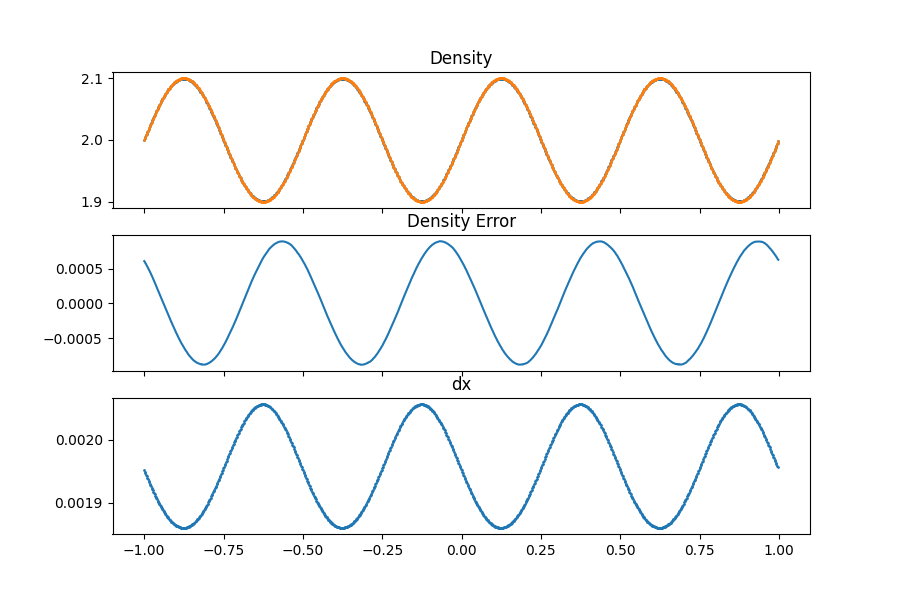

In [52]:
fig, axis = plt.subplots(3, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)

x = particles_l.positions[:,0].cpu().numpy()
targetDensity = pdf(particles_l.positions[:,0].cpu().numpy())
currentDensity = densities.cpu().numpy()

axis[0,0].scatter(particleSystem.systemState.positions.cpu().numpy(), currentDensity, s = 1)
axis[0,0].scatter(particleSystem.systemState.positions.cpu().numpy(), targetDensity, s = 1)

axis[0,0].set_title('Density')

axis[1,0].plot(particleSystem.systemState.positions.cpu().numpy(), (currentDensity - targetDensity))
axis[1,0].set_title('Density Error')

axis[2,0].scatter(x[:-1], x[1:] - x[:-1], s = 1)
axis[2,0].set_title('dx')



In [53]:
import torch
import torch.nn as nn



def getActivationFunctions():
    return ['elu', 'relu', 'hardtanh', 'hardswish', 'selu', 'celu', 'leaky_relu', 'prelu', 'rrelu', 'glu', 'gelu', 'logsigmoid', 'hardshrink', 'tanhshrink', 'softsign', 'softplus', 'softmin', 'softmax', 'softshrink', 'log_softmax', 'tanh', 'sigmoid', 'hardsigmoid', 'silu', 'mish']
def getActivationLayer(function: str):
    if function == 'elu':
        return nn.ELU()
    elif function == 'relu':
        return nn.ReLU()
    elif function == 'hardtanh':
        return nn.Hardtanh()
    elif function == 'hardswish':
        return nn.Hardswish()
    elif function == 'selu':
        return nn.SELU()
    elif function == 'celu':
        return nn.CELU()
    elif function == 'leaky_relu':
        return nn.LeakyReLU()
    elif function == 'prelu':
        return nn.PReLU()
    elif function == 'rrelu':
        return nn.RReLU()
    elif function == 'glu':
        return nn.GLU()
    elif function == 'gelu':
        return nn.GELU()
    elif function == 'logsigmoid':
        return nn.LogSigmoid()
    elif function == 'hardshrink':
        return nn.Hardshrink()
    elif function == 'tanhshrink':
        return nn.Tanhshrink()
    elif function == 'softsign':
        return nn.Softsign()
    elif function == 'softplus':
        return nn.Softplus()
    elif function == 'softmin':
        return nn.Softmin()
    elif function == 'softmax':
        return nn.Softmax()
    elif function == 'softshrink':
        return nn.Softshrink()
    elif function == 'log_softmax':
        return nn.LogSoftmax()
    elif function == 'tanh':
        return nn.Tanh()
    elif function == 'sigmoid':
        return nn.Sigmoid()
    elif function == 'hardsigmoid':
        return nn.Hardsigmoid()
    elif function == 'silu':
        return nn.SiLU()
    elif function == 'mish':
        return nn.Mish()
    else:
        raise ValueError(f'Unknown activation function: {function}')
    
# for activation in getActivationFunctions():
#     print(activation, getActivationLayer(activation), getActivationFunction(activation))

class TransposeLayer(nn.Module):
    def __init__(self, dim1=0, dim2=1):
        super(TransposeLayer, self).__init__()
        self.dim1 = dim1
        self.dim2 = dim2
    def forward(self, input):
        return torch.transpose(input, self.dim1, self.dim2)

import numpy as np
def buildMLPwActivation(layers, inputFeatures = 1, gain = 1/np.sqrt(34), activation = 'gelu', norm = False, groups = 1, preNorm = False, postNorm = False, noLinear = False, bias = True):
    # print(f'layers: {layers}, inputFeatures: {inputFeatures}, gain: {gain}, activation: {activation}, norm: {norm}, channels: {channels}, preNorm: {preNorm}, postNorm: {postNorm}, noLinear: {noLinear}')
    activationFn = getActivationLayer(activation)
    modules = []
    if preNorm:
        modules.append(TransposeLayer(1,2))
        # print(f'groups: {groups[0] if isinstance(groups, list) else groups}, inputFeatures: {inputFeatures}')
        modules.append(nn.GroupNorm(groups[0] if isinstance(groups,list) else groups, inputFeatures))
        modules.append(TransposeLayer(1,2))
    if not noLinear:
        if len(layers) > 1:
            for i in range(len(layers) - 1):
                modules.append(nn.Linear(inputFeatures if i == 0 else layers[i-1],layers[i]))
    #             torch.nn.init.uniform_(modules[-1].weight,-0.5, 0.5)
                torch.nn.init.xavier_normal_(modules[-1].weight,1)
        #         torch.nn.init.zeros_(modules[-1].weight)
                torch.nn.init.zeros_(modules[-1].bias)
                # modules.append(nn.BatchNorm1d(layers[i]))
                if norm:
                    modules.append(TransposeLayer(1,2))
                    # print(f'groups: {groups}, layers[i]: {layers[i]}')
                    modules.append(nn.GroupNorm(groups[i] if isinstance(groups,list) else groups, layers[i]))
                    modules.append(TransposeLayer(1,2))
                modules.append(activationFn)
            modules.append(nn.Linear(layers[-2],layers[-1], bias = bias))
        else:
            modules.append(nn.Linear(inputFeatures,layers[-1], bias = bias)  )
        torch.nn.init.xavier_normal_(modules[-1].weight,gain)
        if bias:
            torch.nn.init.zeros_(modules[-1].bias)     
    if postNorm:
        modules.append(TransposeLayer(1,2))
        # print(f'groups: {channels}, layers[-1]: {layers[-1]}')
        # print(f'groups: {groups[-1] if isinstance(groups,list) else groups}, layers[-1]: {layers[-1]}')
        modules.append(nn.GroupNorm(groups[-1] if isinstance(groups,list) else groups, layers[-1]))
        modules.append(TransposeLayer(1,2)) 
    return nn.Sequential(*modules)

def buildMLPwDict(properties : dict):
    layout = properties['layout'] if 'layout' in properties else []
    output = properties['output']
    inputFeatures = properties['inputFeatures']
    groups = properties['channels'] if 'channels' in properties else 1
    gain = properties['gain'] if 'gain' in properties else 1/np.sqrt(34)
    activation = properties['activation'] if 'activation' in properties else 'celu'
    norm = properties['norm'] if 'norm' in properties else True
    preNorm = properties['preNorm'] if 'preNorm' in properties else False
    postNorm = properties['postNorm'] if 'postNorm' in properties else False
    noLinear = properties['noLinear'] if 'noLinear' in properties else False

    mlp = buildMLPwActivation(layout + [output], inputFeatures, gain = gain, activation = activation, norm = norm, groups = groups, preNorm = preNorm, postNorm = postNorm, noLinear = noLinear, bias = properties['bias'] if 'bias' in properties else True)
    return mlp


In [54]:

display(mlp)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): CELU(alpha=1.0)
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In [73]:
from sphMath.neighborhood import computeDistanceTensor

i, j = sparseNeighborhood.row, sparseNeighborhood.col

rij, xij = computeDistanceTensor(sparseNeighborhood, normalize=True, mode = 'gather')
hij = particles_l.supports[i]

In [56]:
from sphMath.sphOperations.shared import scatter_sum
from sphMath.operations import sph_op
import torch.autograd as autograd

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): CELU(alpha=1.0)
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): CELU(alpha=1.0)
  (6): Linear(in_features=32, out_features=1, bias=True)
)

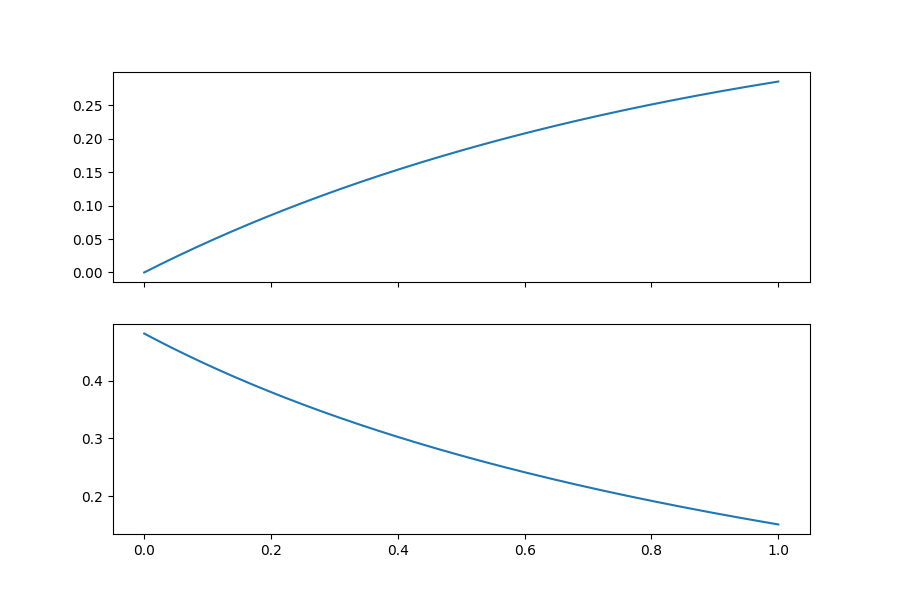

In [140]:
mlp = buildMLPwDict({
    'layout': [32, 32, 32],
    'output': 1,
    'inputFeatures': 1,
    'activation': 'celu',
    'norm': False,
    'preNorm':False,
    'postNorm': False,
    'gain': 1
})
mlp = mlp.train()
optimizer = torch.optim.Adam(mlp.parameters(), lr = 1e-3)
display(mlp)


x = torch.linspace(0, 1, 256, device = device, dtype = dtype)
x.requires_grad = True
h = particles_l.supports.min()

# W = mlp(torch.stack([torch.ones_like(x) * h, x], dim = -1))
W = mlp(x.view(-1,1))
gradW = autograd.grad(outputs=W, inputs=x, grad_outputs=torch.ones_like(W), create_graph=True)[0]

fig, axis = plt.subplots(2, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)
axis[0,0].plot(x.detach().cpu().numpy(), W.cpu().detach().numpy())
axis[1,0].plot(x.detach().cpu().numpy(), gradW.cpu().detach().numpy())


In [141]:
neighborhood, sparseNeighborhood = buildNeighborhood(simulationState, simulationState, domain, 1.4, 'superSymmetric')
actualNeighbors = filterNeighborhood(sparseNeighborhood)

i, j = actualNeighbors.row, actualNeighbors.col
rij, xij = computeDistanceTensor(actualNeighbors, normalize=False, mode = 'gather')
W = solverConfig['kernel'].eval(xij, hij)

In [142]:
W.min(), W.max()

(tensor(1.4247e-09), tensor(42.6667))

In [161]:
for it in (t:= tqdm(range(1000))):
    rij, xij = computeDistanceTensor(actualNeighbors, normalize=False, mode = 'gather')
    hij = particles_l.supports[i]

    optimizer.zero_grad()
    input = torch.stack([hij, rij], dim = -1).to(torch.float32)
    input = (rij / hij).view(-1,1)
    input.requires_grad = True
    output = mlp(input)

    W = solverConfig['kernel'].eval(xij, hij)
    gradW = solverConfig['kernel'].jacobian(xij, hij)

    # print(W.min(), W.max())

    # print(W.shape)

    grad_outputs = torch.ones_like(output)
    gradients = autograd.grad(outputs=output, inputs=input, grad_outputs=grad_outputs, create_graph=True)
    grad_x = gradients[0][:,0]
    # grad_h = gradients[0][:,0]

    rho = computeDensity(simulationState, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather')
    simulationState.densities = rho
    rhoGrad = sph_op(simulationState, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather', 'gradient', gradientMode = 'difference', quantity=rho)[:,0]

    rho_hat = scatter_sum(output[:,0] * particles_l.masses[j], i, dim = 0, dim_size = particles_l.positions.shape[0])
    fac = particles_l.masses[j] / rho[j] * (rho[j] - rho[i]) #/ hij
    
    rhoGrad_hat = scatter_sum(fac * grad_x, i, dim = 0, dim_size = particles_l.positions.shape[0])

    # print(rho.shape, rho_hat.shape)
    # print((rho-rho_hat).shape)
    # break

    rho_loss = (rho_hat - rho).pow(2).mean()
    grad_loss = (rhoGrad_hat - rhoGrad).pow(2).mean()

    loss = (W - output[:,0]).pow(2).mean()
    # loss = rho_loss + grad_loss
    loss.backward()

    # rho_loss.backward()
    optimizer.step()

    # t.set_description(f'loss: {loss.item():.2e}, rho_loss: {rho_loss.item():.2e}')
    t.set_description(f'rho_loss: {rho_loss.item():.2e}, grad_loss: {grad_loss.item():.2e}')

print(rho_loss, grad_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [162]:
print(rhoGrad_hat)
print(rhoGrad)

tensor([-0.0004, -0.0003, -0.0002,  ..., -0.0007, -0.0006, -0.0005],
       grad_fn=<ScatterAddBackward0>)
tensor([1.2408, 1.2403, 1.2390,  ..., 1.2379, 1.2397, 1.2406])


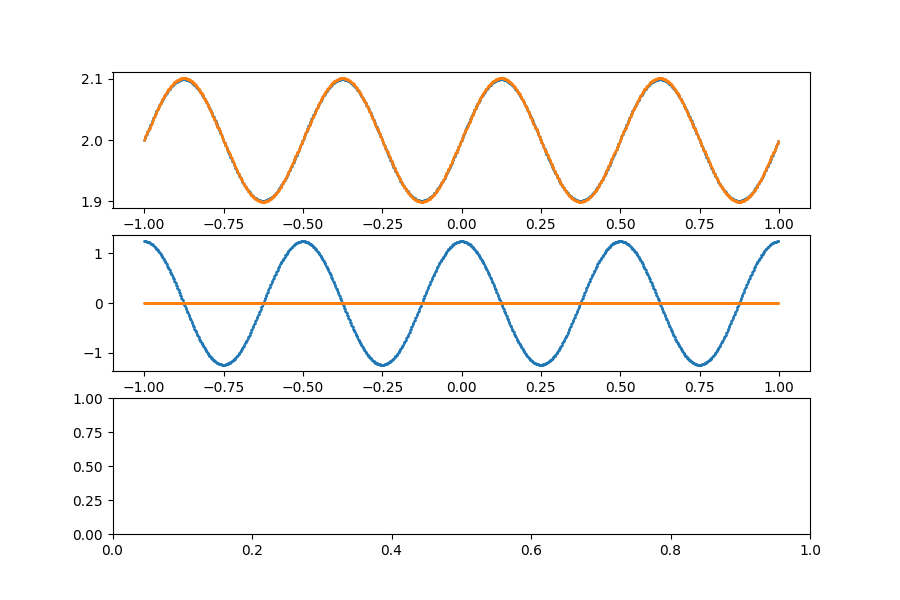

In [163]:
fig, axis = plt.subplots(3, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

x = particles_l.positions[:,0].detach().cpu().numpy()
axis[0,0].scatter(x, rho.detach().cpu().numpy(), s = 1)
axis[0,0].scatter(x, rho_hat.detach().cpu().numpy(), s = 1)


axis[1,0].scatter(x, rhoGrad.detach().cpu().numpy(), s = 1)
axis[1,0].scatter(x, rhoGrad_hat.detach().cpu().numpy(), s = 1)

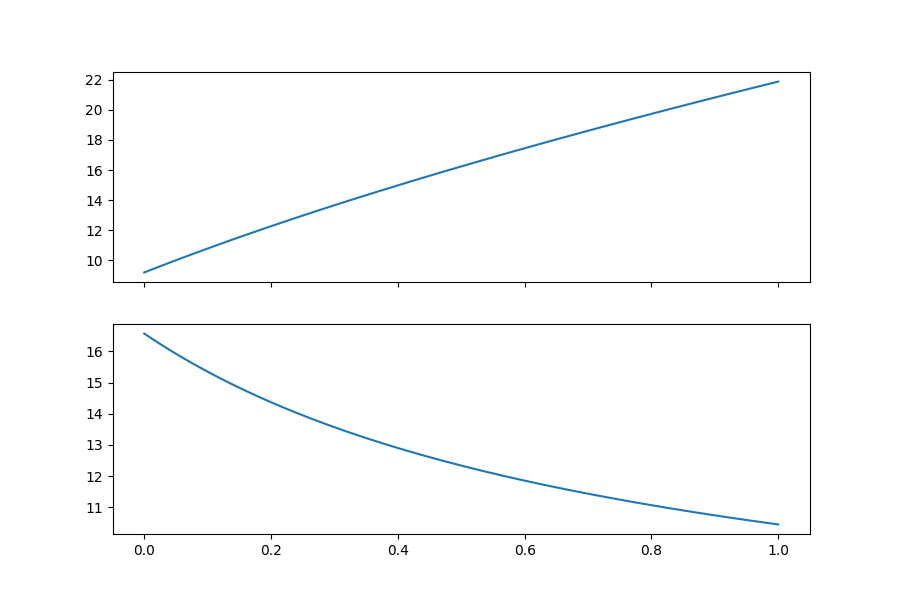

In [134]:
x = torch.linspace(0, 1, 256, device = device, dtype = dtype)
x.requires_grad = True
h = particles_l.supports.min()

# W = mlp(torch.stack([torch.ones_like(x) * h, x], dim = -1))
W = mlp(x.view(-1,1))
gradW = autograd.grad(outputs=W, inputs=x, grad_outputs=torch.ones_like(W), create_graph=True)[0]

fig, axis = plt.subplots(2, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)
axis[0,0].plot(x.detach().cpu().numpy(), W.cpu().detach().numpy())
axis[1,0].plot(x.detach().cpu().numpy(), gradW.cpu().detach().numpy())


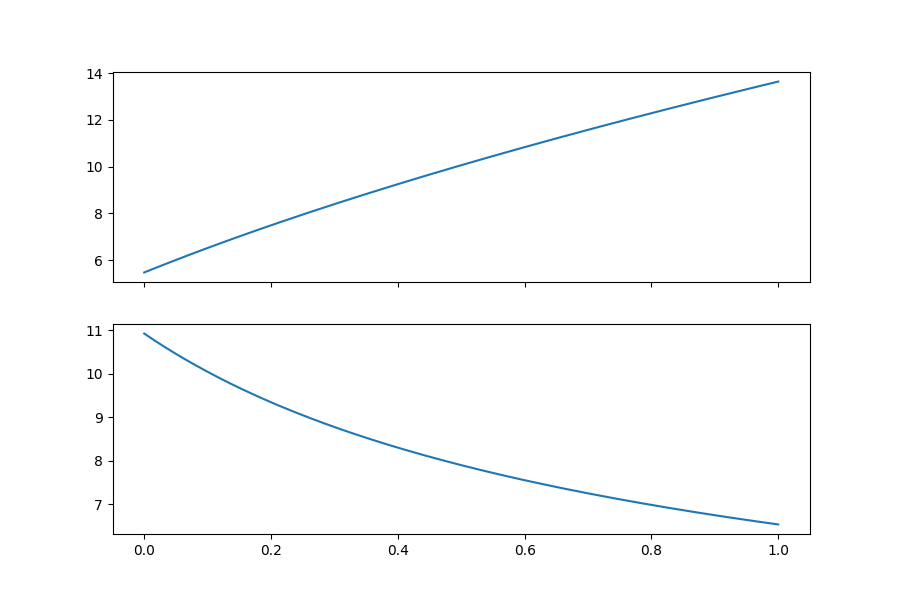